<div style="background-color:rgba(78, 188, 130, 0.05); text-align:center; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(78, 188, 130, 1.0); color: #000000;">

<img src="figs/qr_logo.png" width="700"/>

<h1><strong>Quantum Summer School</strong></h1>

<h2><strong>Episode 4</strong></h2>

<h3><strong>Circuit Composition & Control Flow</strong></h3>

</div>

*In this session, we’ll explore gate decomposition, simplification, composition, and quantum control flow.*

<div style="background-color:rgba(255, 248, 240, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 0, 1.0); color: #000000;">

## Objectives
1. Understand what a univeral gate set is and how we approach decomposing quantum gates.
2. Implement the entanglement swapping protocol.

<div/>

## Setup & Imports

In [1]:
from QuantumRingsLib import QuantumRingsProvider, QuantumRegister, ClassicalRegister, QuantumCircuit, job_monitor
# import qiskit versions of QuantumCircuit, QuantumRegister, ClassicalRegister so we can draw statevectors in latex
from qiskit import QuantumCircuit as qkQuantumCircuit
from qiskit import QuantumRegister as qkQuantumRegister
from qiskit import ClassicalRegister as qkClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from jupyterquiz import display_quiz

provider = QuantumRingsProvider(
    token='rings-128.RudMvYqCFOd2CE6mF7G4Xo5NANQKv54K',
    name='i20ph049@phy.svnit.ac.in'
)
backend = provider.get_backend("scarlet_quantum_rings")

## Helper Functions

Bit List: return a list of all bit strings of length num_bits

In [2]:
def bit_list(num_bits):
    bit_strings = [bin(bit)[2:].zfill(num_bits) for bit in range(2**num_bits)]
    bit_lists = []
    for string in bit_strings:
        bit_lists.append([int(bit) for bit in string])
    return  bit_strings, bit_lists

Trimmed Counts: provide a counts dictionary (from the output of running a circuit in qiskit or quantum rings) and the bits which you want to keep, and it returns a new counts dictionary only including those bits.

In [3]:
def trimmed_counts(counts, keep_bits, reverse_bit_order=True):

    if len(keep_bits) < 1:
        raise ValueError('You need to keep at least one bit.')
        
    # default in qiskit / quantum rings is reversed bit order
    if reverse_bit_order:
        length = 1
        for key in counts.keys():
            length = max(length, len(key))
        keep_bits = [length-1 - bit for bit in keep_bits]

    new_counts = {}
    for key, val in counts.items():
        new_key = ''
        for bit in keep_bits:
            new_key += key[bit]
        if new_key not in new_counts.keys():
            new_counts[new_key] = 0
        new_counts[new_key] += val

    return new_counts

## 1. Classical and Quantum Logic

<div style="background-color:rgba(243, 248, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(101, 174, 247, 1.0); color: #000000;">

Classical and quantum logic are really different from each other, and this is important to keep in mind as we are learning about quantum computation! In classical logic, there are only two possible outcomes: 0 or 1. In quantum logic, the only possible *measurement outcomes* are 0 and 1, but there is a richness not captured by boolean logic. 

We already started making some small quantum circuits to get a feel for quantum logic, but for completeness, let's discuss classical logic too. We will also play around with the NAND gate, a universal gate.

</div>

In [7]:
# classical logic in python

b1 = 0
b2 = 1

## logic here
b1 and b2, b1 or b2, not b1, b1 ^ b2


(0, 1, True, 1)

In [8]:
# Arbitrary logic operation

bit_strings, bit_lists = bit_list(3)
# print(bit_strings) # strings of 0s/1s
# print(bit_lists) # list of 0s/1s

def logic_operation(bits):
    # defaults to True/False, use int() to output 1/0


    return int(bits[0]) and int(bits[1]), int(bits[0]) or int(bits[1]), not bits[0], bits[0] ^ bits[1]

for i, bit_string in enumerate(bit_strings):
    print(f'{bit_string}: \t {logic_operation(bit_lists[i])}')

000: 	 (0, 0, True, 0)
001: 	 (0, 0, True, 0)
010: 	 (0, 1, True, 1)
011: 	 (0, 1, True, 1)
100: 	 (0, 1, False, 1)
101: 	 (0, 1, False, 1)
110: 	 (1, 1, False, 0)
111: 	 (1, 1, False, 0)


In [10]:
# Example: the NAND gate (a universal gate!)

bit_strings, bit_lists = bit_list(2)

def nand(bit0, bit1):
    return not (bit0 and bit1)

for i, bit_string in enumerate(bit_strings):
    print(f'{bit_string}: \t {nand(bit_lists[i][0], bit_lists[i][1])}')

00: 	 True
01: 	 True
10: 	 True
11: 	 False


In [11]:
# Example: decomposing the NOT gate in terms of NAND gates

bit_strings, bit_lists = bit_list(1)

for i, bit_string in enumerate(bit_strings):
    print(f'{bit_string}: \t {nand(bit_lists[i][0], bit_lists[i][0])}')

0: 	 True
1: 	 False


<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

We defined a function for the NAND gate and showed how to decompose NOT, AND, and OR in terms of NAND gates. Try implementing those decompositions. Can you decompose the NOR gate? The XOR gate?

<div/>

### Arbitrary Controlled Rotation Gates

In [12]:
qc = QuantumCircuit(2, name='QSS4.1_controlled_rz')
qc.x(0)
qc.h(1)
qc.crz(np.pi, 0, 1)
qc.h(1)
qc.measure(0)
qc.draw('mpl')

You are using a function call which currently creates an equivalent number of classical bits as that of the qubits.
This functionality will be removed in an upcoming version. You have to explicity create the number of classical bits required.
Example:
num_qubits = 5
num_clbits = 4
qc = QuantumCircuit(num_qubits, num_clbits, name="myCircuit")
          ┌───┐                ┌───┐ 
q[0]:    ■┤ X ├─────■──────────┤ M ├ 
          ├───┤┌────┴────┐┌───┐└─╥─┘ 
q[1]:    ■┤ H ├┤ RZ(pi)  ├┤ H ├──║── 
          └───┘└─────────┘└───┘  ║   
meas: 2/ ■═══════════════════════╩══ 
                                 0   


Job RunningUsing Engine: scarlet_quantum_rings

Job Done.
Ending Job Monitor


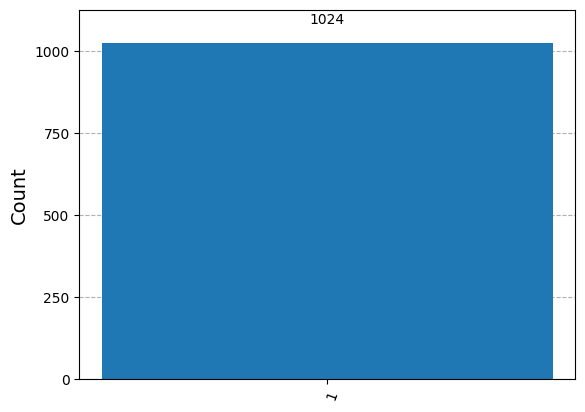

In [13]:
job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
counts = trimmed_counts(counts, keep_bits=[0])
plot_histogram(counts)

### Adaptive Circuits with Mid-Circuit Measurement

In [14]:
# Quantum Teleportation circuit
qc = QuantumCircuit(3, 3, name='QSS4.2_teleportation')
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.measure([0,1], [0,1])
qc.x(2).c_if(qc.clbits[1], 1)
qc.z(2).c_if(qc.clbits[0], 1)
qc.measure(2,2)
qc.draw('mpl')

                         ┌───┐┌───┐                                       
q[0]:    ■────────────■──┤ H ├┤ M ├────────────────────────────────────── 
          ┌───┐     ┌─┴─┐└───┘└─╥─┘┌───┐                                  
q[1]:    ■┤ H ├──■──┤ X ├───────║──┤ M ├───────────────────────────────── 
          └───┘┌─┴─┐└───┘       ║  └─╥─┘┌───┐         ┌───┐         ┌───┐ 
q[2]:    ■─────┤ X ├────────────║────║──┤ X ├─────────┤ Z ├─────────┤ M ├ 
               └───┘            ║    ║  └─┬─┘         └─┬─┘         └─╥─┘ 
meas: 3/ ■══════════════════════╩════╩════╧═════════════╧═════════════╩══ 
                                0    1    meas[1] == 1  meas[0] == 1  2   


Job Running
Using Engine: scarlet_quantum_rings
Job Done.
Ending Job Monitor


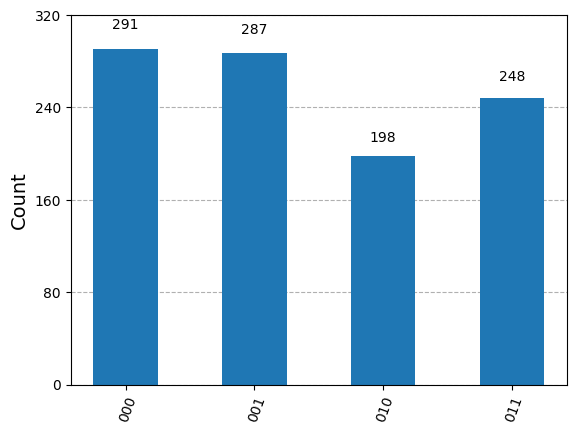

In [15]:
job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Check your understanding: Classical and Quantum Logic

<div class="sec1_ques1" style="display:none">
[
  {
    "question": "What is the quantum analogue of the NOT gate?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"X","correct":true,  "feedback":"✅ The X gate is our bit flip gate."},
      {"answer":"Z","correct":false, "feedback":"❌"},
        {"answer":"H","correct":false, "feedback":"❌"},
    {"answer":"CNOT","correct":false, "feedback":"❌"}
    ]
  }   
]
</div>

<div class="sec1_ques2" style="display:none">
[
  {
    "question": "Are classical gates reversible?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"No","correct":true,  "feedback":"✅ Most classical logic takes in more than one bit and outputs one bit, so it cannot be reversible"},
      {"answer":"Yes","correct":false, "feedback":"❌"}
    ]
  }   
]
</div>

<div class="sec1_ques3" style="display:none">
[
  {
    "question": "Why are quantum gates reversible?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"Quantum gates are unitary operations","correct":true,  "feedback":"✅ All quantum mechanical objects (like qubits) evolve under unitary operations, which are inherently reversible, i.e. quantum gates are reversible by the laws of physics!"},
      {"answer":"Trick question: quantum gates are not reversible!","correct":false, "feedback":"❌"},
    {"answer":"When we apply a quantum state, we don't collapse our qubit state.","correct":false, "feedback":"❌ This is a true statement, but not the full answer."},
    {"answer":"Quantum gates don't change the number of qubits remaining in the computation.","correct":false, "feedback":"❌ This is a true statement, but not the full answer."}
    ]
  }   
]
</div>

<div class="sec1_ques4" style="display:none">
[
  {
    "question": "I apply a quantum gate A. What should I do to reverse A?",
    "type": "multiple_choice",
    "answers": [
      {"answer":"Apply A dagger (Hermitian conjugate)","correct":true,  "feedback":"✅ A quantum gate is unitary and the Hermitian conjugate of a unitary matrix is its inverse, i.e. applying Adagger * A is the same as applying the identity matrix"},
      {"answer":"Apply A again","correct":false, "feedback":"❌"},
    {"answer":"You can't necessarily reverse A","correct":false, "feedback":"❌"},
    {"answer":"Apply X and then A","correct":false, "feedback":"❌"}
    ]
  }   
]
</div>

In [16]:
display_quiz("#sec1_ques1")
display_quiz("#sec1_ques2")
display_quiz("#sec1_ques3")
display_quiz("#sec1_ques4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Gate Decomposition

<div style="background-color:rgba(255, 245, 253, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(255, 142, 235, 1.0); color: #000000;">

The general idea behind decomposing complex gates into gates in a universal gate set is to leverage the unitarity of gates. Recall that all quantum gates are unitary, which means if I have a quantum gate $U$, then:
$$ U^\dagger U = U U^\dagger = \mathbb{1}$$

Another useful tool is the CNOT gate. If the control qubit in the CNOT gate is in the $|0\rangle$ state, then nothing happens. If the control qubit in the CNOT gate is in the $|1\rangle$ state, then the target qubit gets an X gate applied to it (bit flip). 

The general idea behind gate decomposition is to apply both a gate and its inverse, so that they cancel each other out. BUT put a CNOT gate in between them such that under certain conditions (i.e. the control qubit being 1), the gate and its inverse no longer cancel each other out. We saw above that $HXH = Z$, so if we want to make a CPHASE gate (controlled-Z gate), we could do:
$$ (\mathbb{1} \otimes H ) ~\text{CNOT}~ (\mathbb{1} \otimes H ) $$
where $\mathbb{1} \otimes H$ indicates identity applied to the first qubit and Hadamard applied to the second. Then, when the first qubit is in the $|0\rangle$ state, nothing happens, since $HH=\mathbb{1}$, but when the first qubit is in the $|1\rangle$ state, the second qubit experiences $HXH=Z$. Hence, we have a CPHASE gate. Below, we outline two examples: the SWAP gate and the Toffoli gate.

<div/>

### SWAP Gate

You are using a function call which currently creates an equivalent number of classical bits as that of the qubits.
This functionality will be removed in an upcoming version. You have to explicity create the number of classical bits required.
Example:
num_qubits = 5
num_clbits = 4
qc = QuantumCircuit(num_qubits, num_clbits, name="myCircuit")
          ┌───┐   ┌───┐      
q[0]:    ■┤ X ├─╳─┤ M ├───── 
          └───┘ │ └─╥─┘┌───┐ 
q[1]:    ■──────╳───║──┤ M ├ 
                    ║  └─╥─┘ 
meas: 2/ ■══════════╩════╩══ 
                    0    1   
Job Running
Job Done.Using Engine: scarlet_quantum_rings

Ending Job Monitor


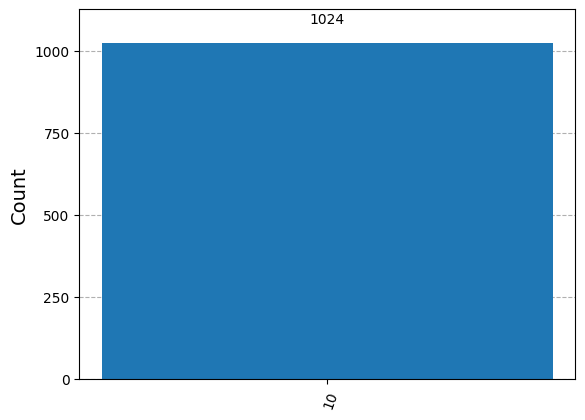

In [20]:
qc = QuantumCircuit(2)

qc.x(0)

qc.swap(0, 1)

qc.measure_all()
qc.draw()

job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

You are using a function call which currently creates an equivalent number of classical bits as that of the qubits.
This functionality will be removed in an upcoming version. You have to explicity create the number of classical bits required.
Example:
num_qubits = 5
num_clbits = 4
qc = QuantumCircuit(num_qubits, num_clbits, name="myCircuit")
          ┌───┐     ┌───┐     ┌───┐      
q[0]:    ■┤ X ├──■──┤ X ├──■──┤ M ├───── 
          └───┘┌─┴─┐└─┬─┘┌─┴─┐└─╥─┘┌───┐ 
q[1]:    ■─────┤ X ├──■──┤ X ├──║──┤ M ├ 
               └───┘     └───┘  ║  └─╥─┘ 
meas: 2/ ■══════════════════════╩════╩══ 
                                0    1   
Job Running
Job Done.
Ending Job Monitor
Using Engine: scarlet_quantum_rings


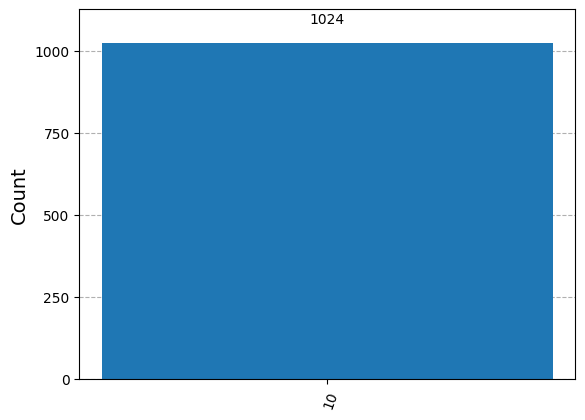

In [21]:
qc = QuantumCircuit(2)

qc.x(0)
#
#
qc.cx(0, 1)
qc.cx(1, 0)
qc.cx(0, 1)

qc.measure_all()
qc.draw()

job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

### Toffoli Gate -- Sleator-Weinfurter Decomposition example

In [22]:
qc = qkQuantumCircuit(3)
qc.csx(1,0)
qc.cx(2,1)
qc.csx(1,0).inverse()
qc.cx(2,1)
qc.csx(2,0)
qc.draw(reverse_bits=True)

q_2: ────────■────────────■────■───
           ┌─┴─┐        ┌─┴─┐  │   
q_1: ──■───┤ X ├───■────┤ X ├──┼───
     ┌─┴──┐└───┘┌──┴───┐└───┘┌─┴──┐
q_0: ┤ Sx ├─────┤ Sxdg ├─────┤ Sx ├
     └────┘     └──────┘     └────┘

In [23]:
basis_states, _ = bit_list(3)

In [24]:
def decomposed_toffoli(qc):
    qc.csx(1,0)
    qc.cx(2,1)
    qc.csx(1,0).inverse()
    qc.cx(2,1)
    qc.csx(2,0)

In [25]:
# example:

state = '011'

qc = qkQuantumCircuit(3)
for i in range(3):
    if state[2-i] == '1':
        qc.x(i)
sv_in = Statevector(qc)

decomposed_toffoli(qc)
sv = Statevector(qc)

display(sv_in.draw('latex'))
display(sv.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
output_states = []

for state in basis_states:
    qc = qkQuantumCircuit(3)
    for i in range(3):
        if state[2-i] == '1':
            qc.x(i)
    
    sv_in = Statevector(qc)
    
    # Toffoli
    decomposed_toffoli(qc)
    
    sv = Statevector(qc)
    print(f"In: \t {sv_in.draw('latex').data[4:7]}")
    print(f"Out: \t {sv.draw('latex').data[4:7]} \n")

In: 	 000
Out: 	 000 

In: 	 001
Out: 	 001 

In: 	 010
Out: 	 010 

In: 	 011
Out: 	 011 

In: 	 100
Out: 	 100 

In: 	 101
Out: 	 101 

In: 	 110
Out: 	 111 

In: 	 111
Out: 	 110 



<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Use the Sleator-Weinfurter decomposition technique to make a CCS gate (S gate with two controls). Hint: what gate squared is equal to S?

<div/>

In [4]:
## your code here
def decomposed_ccs(qc):
    qc.cp(np.pi/4, 1, 0)
    qc.cx(2, 1)
    qc.cp(-np.pi/4, 1, 0)
    qc.cx(2, 1)
    qc.cp(np.pi/4, 2, 0)

In [9]:
# example:

state = '111'

qc = qkQuantumCircuit(3)
for i in range(3):
    if state[2-i] == '1':
        qc.x(i)

sv_in = Statevector(qc)

decomposed_ccs(qc)
sv = Statevector(qc)

display(sv_in.draw('latex'))
display(sv.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Entanglement Swapping

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

We know that Alice and Bob can entangle a qubit if they apply a Hadamard gate and a CNOT. This requires Alice and Bob to interact directly, because CNOT is a two-qubit gate. What if Alice and Bob want to entangle a pair of qubit *without ever interacting directly with each other?* Then they can accomplish this by doing entanglement swapping.

Alice and Bob each start with their own pair of entangled qubits, each in the state $|\Phi^+\rangle$. The total state of the system is:

\begin{align}
|S\rangle &=|\Phi^+\rangle_A\otimes |\Phi^+\rangle_B \\
&=  \frac{1}{2} ( |00\rangle_A + |11\rangle_A )\otimes ( |00\rangle_B + |11\rangle_B ) \\
&=  \frac{1}{2} ( |00\rangle_A|00\rangle_B + |00\rangle_A|11\rangle_B + |11\rangle_A|00\rangle_B+ |11\rangle_A|11\rangle_B ) 
\end{align}

They each send half of their pair to a third party, let's call them Charlie. Now Charlie has two qubits and Alice and Bob each have one. We can describe the system as:

\begin{align}
|S\rangle &=  \frac{1}{2} ( |0\rangle_A|0\rangle_B |00\rangle_C + |0\rangle_A|1\rangle_B|01\rangle_C + |1\rangle_A|0\rangle_B |10\rangle_C + |1\rangle_A|1\rangle_B |11\rangle_C ) 
\end{align}

Recall that the four Bell states form a complete orthonormal basis for all two qubit states! So we can rexpress Charlie's states in the Bell basis.
</div>
$$ $$

**MATH RECAP:**
The four Bell states are:
$$|\Phi^+\rangle =  \frac{1}{\sqrt{2}} ( |00\rangle + |11\rangle )$$
$$|\Phi^-\rangle =  \frac{1}{\sqrt{2}} ( |00\rangle - |11\rangle )$$
$$|\Psi^+\rangle =  \frac{1}{\sqrt{2}} ( |01\rangle + |10\rangle )$$
$$|\Psi^-\rangle =  \frac{1}{\sqrt{2}} ( |01\rangle - |10\rangle )$$

We can express the standard basis ($|00\rangle, |01\rangle, |10\rangle, |11\rangle$) in terms of the Bell basis as:
$$|00\rangle = \frac{1}{\sqrt{2}} (|\Phi^+\rangle + |\Phi^-\rangle) $$
$$|01\rangle = \frac{1}{\sqrt{2}} (|\Psi^+\rangle + |\Psi^-\rangle) $$
$$|10\rangle = \frac{1}{\sqrt{2}} (|\Psi^+\rangle - |\Psi^-\rangle) $$
$$|11\rangle = \frac{1}{\sqrt{2}} (|\Phi^+\rangle - |\Phi^-\rangle) $$
$$ $$

<div style="background-color:rgba(247, 255, 245, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(0, 153, 51, 1.0); color: #000000;">

When we rexpress Charlie's states in the Bell basis, we get:

\begin{align}
|S\rangle &=  \frac{1}{2\sqrt{2}} ( |0\rangle_A|0\rangle_B (|\Phi^+\rangle_C + |\Phi^-\rangle_C) + |0\rangle_A|1\rangle_B (|\Psi^+\rangle_C + |\Psi^-\rangle_C)\\
&~~~~~~~~~~~~ + |1\rangle_A|0\rangle_B (|\Psi^+\rangle_C - |\Psi^-\rangle_C)  + |1\rangle_A|1\rangle_B (|\Phi^+\rangle_C - |\Phi^-\rangle_C) )  \\
&=  \frac{1}{2\sqrt{2}} \bigg[ (|0\rangle_A|0\rangle_B + |1\rangle_A|1\rangle_B )|\Phi^+\rangle_C \\
&~~~~~~~~~~~~ + (|0\rangle_A|0\rangle_B - |1\rangle_A|1\rangle_B )|\Phi^-\rangle_C  \\
&~~~~~~~~~~~~ + (|0\rangle_A|1\rangle_B + |1\rangle_A|0\rangle_B )|\Psi^+\rangle_C  \\
&~~~~~~~~~~~~ + (|0\rangle_A|1\rangle_B - |1\rangle_A|0\rangle_B )|\Psi^-\rangle_C \bigg] \\
\end{align}



Charlie performs a Bell state measurement, which collapses Alice and Bob's state as well. The state which Alice and Bob have at the end is necessarily entangled, but they can manipulate it to get it to the $|\Phi^+\rangle$ state. If Charlie measured odd parity ($|\Psi^\pm\rangle$), then Bob should apply an X gate. If Charlie measured a phase of -1 ($|\Phi^-\rangle$ or $|\Psi^-\rangle$), then Alice should apply a Z gate.

Alice and Bob never interacted directly... they only communicated with Charlie, and yet they end with an entangled pair! Let's implement this below.

</div>

In [12]:
qc = QuantumCircuit(4, 4, name='QSS4.3_entanglement_swap')

# Alice's initial pair is q0 and q1
# Bob's initial pair is q2 and q3
# Alice sends q1 to Charlie and Bob sends q2 to Charlie
# The final entangled pair should be q0 and q3

# Alice entangles her pair
qc.h(0)
qc.cx(0, 1)

# Bob entangles his pair
qc.h(2)
qc.cx(2, 3)

# Alice and Bob send q1 and q2 to Charlie


# Charlie measures in the Bell basis
qc.cx(1,2)
qc.h(1)
qc.measure([1,2],[0,1])

# Alice and Bob apply gates conditional on Charlie's result

qc.z(0).c_if(qc.clbits[0], 1)
qc.x(3).c_if(qc.clbits[1], 1)


qc.measure([0,3],[2,3])
qc.draw()

          ┌───┐                                   ┌───┐                       »
q[0]:    ■┤ H ├──■────────────────────────────────┤ Z ├───────────────────────»
          └───┘┌─┴─┐               ┌───┐┌───┐     └─┬─┘                       »
q[1]:    ■─────┤ X ├────────────■──┤ H ├┤ M ├───────│─────────────────────────»
               └───┘┌───┐     ┌─┴─┐└───┘└─╥─┘┌───┐  │                         »
q[2]:    ■──────────┤ H ├──■──┤ X ├───────║──┤ M ├──│─────────────────────────»
                    └───┘┌─┴─┐└───┘       ║  └─╥─┘  │           ┌───┐         »
q[3]:    ■───────────────┤ X ├────────────║────║────│───────────┤ X ├─────────»
                         └───┘            ║    ║    │           └─┬─┘         »
meas: 4/ ■════════════════════════════════╩════╩════╧═════════════╧═══════════»
                                          0    1    meas[0] == 1  meas[1] == 1»
«          ┌───┐      
«q[0]:    ■┤ M ├───── 
«          └─╥─┘      
«q[1]:    ■──║─────── 
«            ║        
«q[2]

Job Running
Using Engine: Job Done.
Ending Job Monitor
scarlet_quantum_rings


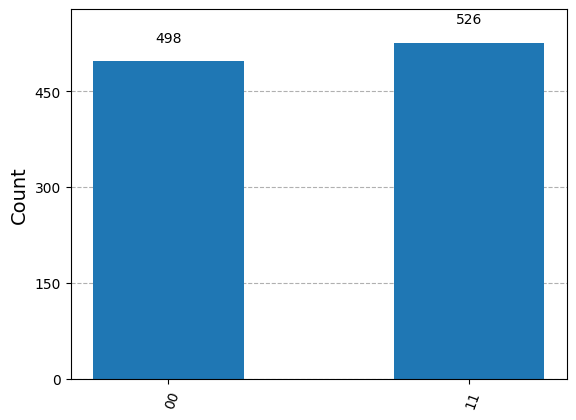

In [13]:
job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
counts = trimmed_counts(counts, keep_bits=[2,3])
plot_histogram(counts)

In [14]:
# Reusable Module

def entanglement_swap(qc, pair_a=[0,1], pair_b=[2,3], cbits_c=[0,1], 
                      pair_a_entangled=False, pair_b_entangled=False):

    # Charlie will receive pair_a[1] and pair_b[0]
    # Alice will be left with pair_a[0] and Bob will be left with pair_b[1]

    # Optional: if pair_a or pair_b is already enangled, 
    # flag that so we skip the entangling portion of the protocol

    pair_c = [pair_a[1], pair_b[0]]

    if not pair_a_entangled: 
        # Alice entangles her pair
        qc.h(pair_a[0])
        qc.cx(pair_a[0], pair_a[1])

    if not pair_b_entangled: 
        # Bob entangles his pair
        qc.h(pair_b[0])
        qc.cx(pair_b[0], pair_b[1])
    
    # Alice and Bob send half of their pairs to Charlie
    
    # Charlie measures in the Bell basis
    qc.cx(pair_c[0], pair_c[1])
    qc.h(pair_c[0])
    qc.measure([pair_c[0], pair_c[1]], [cbits_c[0],cbits_c[1]])
    
    # Alice and Bob apply gates conditional on Charlie's result
    qc.z(pair_a[0]).c_if(qc.clbits[cbits_c[0]], 1)
    qc.x(pair_b[1]).c_if(qc.clbits[cbits_c[1]], 1)

**Question:** Can you build a quantum repeater using our reusable module?

In [17]:
qc = QuantumCircuit(6, 6, name='QSS4.4_quantum_repeater')

##
entanglement_swap(qc, pair_a=[0,1], pair_b=[2,3], cbits_c=[0,1])
qc.barrier()

entanglement_swap(qc, pair_a=[0,3], pair_b=[4,5], cbits_c=[2,3], pair_a_entangled=True)
qc.measure([0,5],[4,5])
qc.draw('mpl')

          ┌───┐                                   ┌───┐                       »
q[0]:    ■┤ H ├──■────────────────────────────────┤ Z ├───────────────────────»
          └───┘┌─┴─┐               ┌───┐┌───┐     └─┬─┘                       »
q[1]:    ■─────┤ X ├────────────■──┤ H ├┤ M ├───────│─────────────────────────»
               └───┘┌───┐     ┌─┴─┐└───┘└─╥─┘┌───┐  │                         »
q[2]:    ■──────────┤ H ├──■──┤ X ├───────║──┤ M ├──│─────────────────────────»
                    └───┘┌─┴─┐└───┘       ║  └─╥─┘  │           ┌───┐         »
q[3]:    ■───────────────┤ X ├────────────║────║────│───────────┤ X ├─────────»
                         └───┘            ║    ║    │           └─┬─┘         »
q[4]:    ■────────────────────────────────║────║────│─────────────│───────────»
                                          ║    ║    │             │           »
q[5]:    ■────────────────────────────────║────║────│─────────────│───────────»
                                        

Job Running
Job Done.
Ending Job Monitor
Using Engine: scarlet_quantum_rings


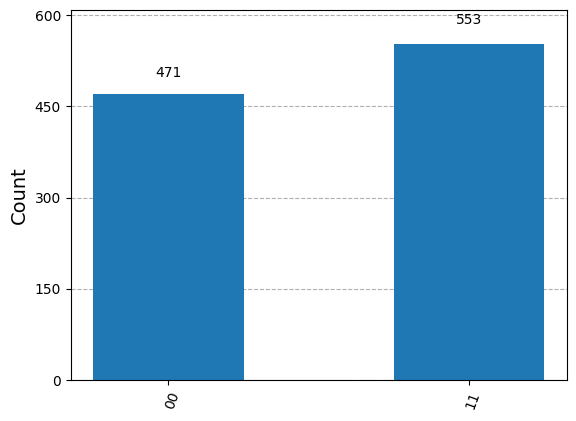

In [16]:
job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
counts = trimmed_counts(counts, keep_bits=[4,5])
plot_histogram(counts)

<div style="background-color:rgba(252, 245, 255, 1.0); text-align:left; vertical-align: middle; padding:20px 0;border:3px; border-style:solid; padding: 0.5em; border-color: rgba(190, 111, 227, 1.0); color: #000000;">

### Challenge Problem: 

Make a quantum repeater with three entanglement swaps!

<div/>

In [18]:
# Define the entanglement swap function as provided
def entanglement_swap(qc, pair_a=[0,1], pair_b=[2,3], cbits_c=[0,1], 
                      pair_a_entangled=False, pair_b_entangled=False):
    # Charlie will receive pair_a[1] and pair_b[0]
    # Alice will be left with pair_a[0] and Bob will be left with pair_b[1]
    
    pair_c = [pair_a[1], pair_b[0]]
    
    # Entangle pair_a if not already entangled
    if not pair_a_entangled: 
        qc.h(pair_a[0])
        qc.cx(pair_a[0], pair_a[1])
    
    # Entangle pair_b if not already entangled
    if not pair_b_entangled: 
        qc.h(pair_b[0])
        qc.cx(pair_b[0], pair_b[1])
    
    # Charlie performs Bell measurement
    qc.cx(pair_c[0], pair_c[1])
    qc.h(pair_c[0])
    qc.measure([pair_c[0], pair_c[1]], [cbits_c[0], cbits_c[1]])
    
    # Apply corrections based on Charlie's measurement
    qc.z(pair_a[0]).c_if(qc.clbits[cbits_c[0]], 1)
    qc.x(pair_b[1]).c_if(qc.clbits[cbits_c[1]], 1)

# Create quantum circuit with 8 qubits and 8 classical bits
qc = QuantumCircuit(8, 8, name='quantum_repeater_three_swaps')

# First entanglement swap: entangle qubits 0 and 3
entanglement_swap(qc, pair_a=[0,1], pair_b=[2,3], cbits_c=[0,1], 
                  pair_a_entangled=False, pair_b_entangled=False)
qc.barrier()

# Second entanglement swap: entangle qubits 0 and 5
entanglement_swap(qc, pair_a=[0,3], pair_b=[4,5], cbits_c=[2,3], 
                  pair_a_entangled=True, pair_b_entangled=False)
qc.barrier()

# Third entanglement swap: entangle qubits 0 and 7
entanglement_swap(qc, pair_a=[0,5], pair_b=[6,7], cbits_c=[4,5], 
                  pair_a_entangled=True, pair_b_entangled=False)
qc.barrier()

# Measure the end qubits to verify entanglement
qc.measure([0,7], [6,7])

qc.draw('mpl')

          ┌───┐                                   ┌───┐                       »
q[0]:    ■┤ H ├──■────────────────────────────────┤ Z ├───────────────────────»
          └───┘┌─┴─┐               ┌───┐┌───┐     └─┬─┘                       »
q[1]:    ■─────┤ X ├────────────■──┤ H ├┤ M ├───────│─────────────────────────»
               └───┘┌───┐     ┌─┴─┐└───┘└─╥─┘┌───┐  │                         »
q[2]:    ■──────────┤ H ├──■──┤ X ├───────║──┤ M ├──│─────────────────────────»
                    └───┘┌─┴─┐└───┘       ║  └─╥─┘  │           ┌───┐         »
q[3]:    ■───────────────┤ X ├────────────║────║────│───────────┤ X ├─────────»
                         └───┘            ║    ║    │           └─┬─┘         »
q[4]:    ■────────────────────────────────║────║────│─────────────│───────────»
                                          ║    ║    │             │           »
q[5]:    ■────────────────────────────────║────║────│─────────────│───────────»
                                        

Job Running
Using Engine: scarlet_quantum_rings
Job Done.
Ending Job Monitor


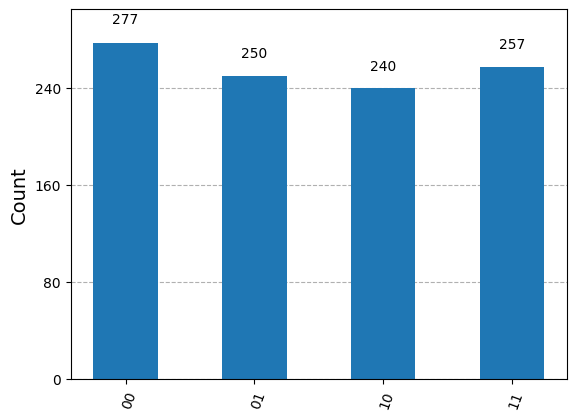

In [19]:
job = backend.run(qc, shots=1024)
job_monitor(job)
result = job.result()
counts = result.get_counts()
counts = trimmed_counts(counts, keep_bits=[4,5])
plot_histogram(counts)